In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.utilities import read_values, multiple_assign, set_trainable
from gpflow.inducing_variables import InducingPoints
import gpmaniflow
from gpmaniflow.models.GPR import GPR

import gpmaniflow.samplers
from gpmaniflow.samplers import initialize_sampler
from gpmaniflow.curves import BezierCurve

In [2]:
pX = np.reshape(np.random.uniform(-2, 2, 200*2), [200, 2])
X = np.random.uniform(-3, 3, 200*2)[:, None]
X = np.reshape(X, [200, 2])
Y = 2 * X[:,0] ** 2 + 1 * X[:,1] + np.random.randn(200) * 0.1
Y = np.reshape(Y, [200,1])

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

In [3]:
kernel = gpflow.kernels.SquaredExponential()

model = GPR((X,Y), kernel)

training_loss = model.training_loss_closure(compile=True)
optimizer = tf.keras.optimizers.Adam(0.05)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
elbo_hist = []
for step in range(3000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

LML = model.log_marginal_likelihood()

Step: 0, Mini batch elbo: -807.480053510283
Step: 50, Mini batch elbo: -488.27030311279884
Step: 100, Mini batch elbo: -290.7731404673062
Step: 150, Mini batch elbo: -188.64893934203252
Step: 200, Mini batch elbo: -151.87100352249013
Step: 250, Mini batch elbo: -129.20629820022094
Step: 300, Mini batch elbo: -113.09164843828677
Step: 350, Mini batch elbo: -100.75181171070363
Step: 400, Mini batch elbo: -90.84939458180281
Step: 450, Mini batch elbo: -82.63975400938779
Step: 500, Mini batch elbo: -75.66743164018561
Step: 550, Mini batch elbo: -69.63460433746678
Step: 600, Mini batch elbo: -64.33650362245021
Step: 650, Mini batch elbo: -59.62671117794497
Step: 700, Mini batch elbo: -55.39717648603789
Step: 750, Mini batch elbo: -51.566065302834375
Step: 800, Mini batch elbo: -48.07003460350023
Step: 850, Mini batch elbo: -44.85913708686974
Step: 900, Mini batch elbo: -41.893353842827196
Step: 950, Mini batch elbo: -39.14017116616981
Step: 1000, Mini batch elbo: -36.57284749721805
Step: 10

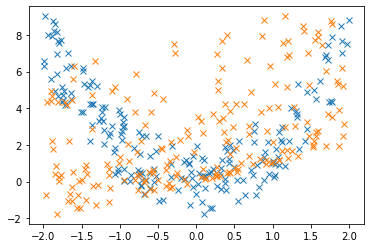

In [4]:
pmu, pvar = model.predict_f(pX)

plt.plot(pX, pmu, 'x')

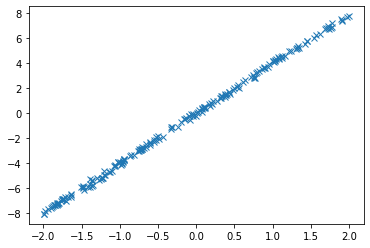

In [9]:
dmu, dvar = model.predict_df(pX)
plt.plot(pX[:,0], dmu[:,:,0], "x")

In [10]:
model.MatheronSampler = initialize_sampler(from_df = True)

I'm here


In [11]:
J = model.MatheronSampler(pX)
J.shape

TensorShape([1, 200, 2, 1])

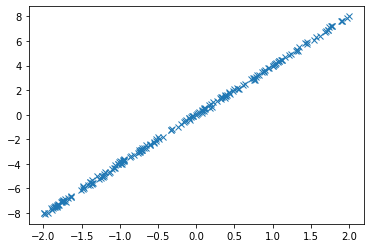

In [12]:
plt.plot(pX[:,0], J[0,:,0,0], 'x')